In [377]:
%env CUDA_VISIBLE_DEVICES=0
import torch
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import math

env: CUDA_VISIBLE_DEVICES=0


# Set up Cuda

In [378]:
CUDA = torch.cuda.is_available()
#CUDA = False
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


# Define functions to generate and check learning parameters

In [379]:
def check_params(out_len, filt_len, in_len, stride):
    n_true = (in_len - 1)*stride + filt_len
    f_true = out_len - (in_len - 1)*stride
    k_true = (out_len - filt_len)/stride + 1
    s_true = (out_len - filt_len)/(in_len - 1)
    
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return False
    
    if(out_len != n_true or filt_len != f_true or in_len != k_true or not k_true.is_integer() or not s_true.is_integer()):
        return False
    
    return True

#get stride given three other parameters; returns -1 if input is an invalid combo
def get_s(out_len, filt_len, in_len):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(in_len, int))):
        return -1
    
    stride = (out_len - filt_len)/(in_len - 1)
    
    if(not stride.is_integer()):
        return -1
    
    return int(stride)

def get_k(out_len, filt_len, stride):
    if(not (isinstance(out_len, int) and isinstance(filt_len, int) and isinstance(stride, int))):
        return -1
    
    in_len = (out_len - filt_len)/stride + 1
    
    if(not in_len.is_integer()):
        return -1
    
    return int(in_len)

def get_f(out_len, in_len, stride):
    if(not (isinstance(out_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    filt_len = out_len - (in_len - 1)*stride
    
    return filt_len

def get_n(filt_len, in_len, stride):
    if(not (isinstance(filt_len, int) and isinstance(in_len, int) and isinstance(stride, int))):
        return -1
    
    out_len = (in_len - 1)*stride + filt_len
    
    return out_len

# Check the generator functions

In [380]:
n = 64
f = 16
k = 4
s = 16

print(check_params(n,f,k,s))

#print(get_n(f,k,s) == 6)
#print(get_f(n,k,s) == 2)
#print(get_k(n,f,s) == 3)
#print(get_s(n,f,k) == 2)

True


# Define functions to generate the weight vector and latent matrix

In [381]:
def gen_weights(f, nc, cuda):
    weights = torch.zeros((f*nc))
    weights.data.normal_(0, 1)
    
    if(cuda):
        weights = weights.cuda()
    
    return weights

def gen_z_block(k, s, cuda):
    z = torch.zeros(k)
    z.data.normal_(0, 1)
    
    if(cuda):
        z = z.cuda()

    z_strided = torch.zeros((k - 1)*s + 1)

    if(cuda):
        z_strided = z_strided.cuda()

    inds = [i*s for i in range(k)]

    z_strided[inds] = z
    
    return z_strided

def gen_z_mat(n, f, k, s, cuda):
    z_block = gen_z_block(k, s, cuda)
    block_len = list(z_block.shape)[0]
    
    z_mat = torch.zeros((n, f))
    
    if(cuda):
        z_mat = z_mat.cuda()
    
    for i in range(f):
        z_mat[i:block_len + i, i] = z_block
        
    return z_mat

def gen_z_latent(n, f, k, s, nc, cuda):
    z_latent = torch.zeros((n, f*nc))
    
    if(cuda):
        z_latent = z_latent.cuda()
    
    for i in range(nc):
        z_latent[:, i*f:i*f+f] = gen_z_mat(n, f, k, s, cuda)
    
    return z_latent

# Check the generator functions

In [382]:
nc = 10

weights = gen_weights(f, nc, CUDA)
z_block = gen_z_block(k, s, CUDA)
z_mat = gen_z_mat(n, f, k, s, CUDA)
Z = gen_z_latent(n, f, k, s, nc, CUDA)

print(weights)
print(z_block)
print(z_mat)
print(Z)

tensor([-0.0561,  0.3410,  0.8746,  0.7644,  0.0110, -0.2476,  0.2393,  0.9917,
         0.2163, -0.0198,  0.8652,  1.0348, -0.3928,  1.1703, -0.7434, -0.1768,
         0.2019,  0.2613,  0.2390, -0.0534, -1.5325, -1.7040, -1.7024, -0.7805,
         1.5660, -1.0356,  0.8549, -1.3768, -0.1456, -1.7905, -1.1779,  0.5389,
         0.6944,  2.9353, -0.1427,  2.1912,  0.8235,  0.0298, -1.5826,  0.0825,
         1.1240, -2.0726,  0.1222, -1.6173,  0.3572,  0.4242,  0.6117, -0.3860,
        -0.3300, -0.7765, -0.5646, -0.4263, -0.1650,  1.1695,  2.3922,  0.4067,
        -1.8787,  0.3087, -2.1572, -0.7434, -1.2416,  0.4673,  0.9798,  1.0427,
        -2.3093,  0.7449, -1.0321,  1.9203,  0.5577, -0.5337, -2.3138,  0.4987,
        -0.7548, -0.2333,  0.9150,  0.5868, -0.4215, -0.6239, -0.6837, -1.3550,
        -1.1119, -1.5555, -0.4381,  0.9369,  0.4817, -1.5611,  0.3611, -0.0301,
         1.1830, -0.7646,  1.0638, -0.8885,  0.4212,  1.3436, -0.3628,  0.1898,
         0.7106,  0.1499,  0.7423,  1.75

# Define gradient function

In [383]:
def get_gradient(y, Z, w):
    return torch.matmul(Z.t(), y) - torch.matmul(torch.matmul(Z.t(), Z), w)

# Define Gradient Descent

In [384]:
def gradient_descent(y, Z, w, stepsize, num_iter, log = False):
    w_t = w
    
    if(log):
        mse = torch.nn.MSELoss().type(dtype)
        mse_log = torch.zeros((num_iter))
    
    for i in range(num_iter):
        w_t = w_t + stepsize*get_gradient(y, Z, w_t)
        
        if(log):
            mse_log[i] = mse(y, torch.matmul(Z, w_t))
    
    if(log):
        return (w_t, mse_log)
    
    return w_t

# Create Target

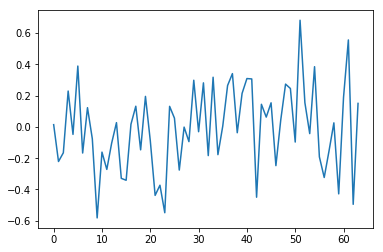

In [385]:
X_OUTPUT = np.arange(n)

#y0 = np.sin(2 * np.pi *X_OUTPUT / n) + 0.25 * np.random.randn(n)
y0 = 0.25 * np.random.randn(n)
y = torch.tensor(y0).type(dtype)

if(CUDA):
    y = y.cuda()

plt.figure()
plt.plot(X_OUTPUT, y0)
plt.show()

# Perform Linear Regression

In [386]:
stepsize = 1e-3
NUM_ITER = 500

weights, log = gradient_descent(y, Z, weights, stepsize, NUM_ITER, True)

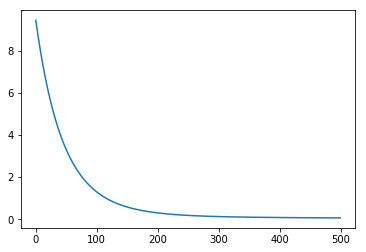

In [387]:
plt.figure()
plt.plot(range(NUM_ITER), log.cpu().numpy())
plt.show()